In [1]:
import os
import sys
sys.path.insert(0,'..')
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, colors
from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from src.utils.hdf_tools import load_from_hdf_with_regex
from src.utils.dataset_utils import u_diode_data_to_df
from src.datasets.rb_fpa_full_quench_V2 import RBFPAFullQuench_V2
from src.datasets.rb_fpa_prim_quench_ee_plateau_V2 import RBFPAPrimQuenchEEPlateau_V2
from src.utils.frequency_utils import get_fft_of_DataArray, scale_fft_amplitude
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_NMF, plot_nmf_event_composition, plot_avg_component_weight, plot_distribution_over_column, plot_component_distribution, plot_cweight_distribution_all_data

# Define plot style

In [2]:
import matplotlib.font_manager
matplotlib.font_manager._rebuild()

AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

In [29]:
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

cfgdir = mpl.get_configdir()

p = Path(cfgdir)
stylelib = (p / 'stylelib')
stylelib.mkdir(exist_ok=True)
path = stylelib / 'mycustomstyle.mplstyle'

path.write_text(r'''
# Matplotlib style for general scientific plots

# Set color cycle
axes.prop_cycle : cycler('color', ['0C5DA5', 'FF9500', '00B945', 'FF2C00', '845B97', '474747', '9e9e9e'])

# Set default figure size 
figure.figsize : 3.5, 2.625 #3.5, 

font.size           : 10.0
axes.labelsize      : 10.0  # fontsize of the x any y labels

# Set x axis
xtick.direction : in
xtick.major.size : 3
xtick.major.width : 0.5
xtick.minor.size : 1.5
xtick.minor.width : 0.5
xtick.minor.visible :   True
xtick.top : True

# Set y axis
ytick.direction : in
ytick.major.size : 3
ytick.major.width : 0.5
ytick.minor.size : 1.5
ytick.minor.width : 0.5
ytick.minor.visible :   True
ytick.right : True

# Set line widths
axes.linewidth : 0.5
grid.linewidth : 0.5
lines.linewidth : 1.
axes.grid : False

# Remove legend frame
legend.frameon : False

# Always save as 'tight'
savefig.bbox : tight
savefig.pad_inches : 0.05



# Use LaTeX for math formatting
text.usetex : False
text.latex.preamble : \usepackage{amsmath}
''')

mpl.style.reload_library()
mpl.style.use('mycustomstyle')
#sorted(mpl.style.available)

In [8]:

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
})

# Magnet Voltage

In [13]:
# Load context data
context_path = Path("../data/MP3_context_data/20230313_RB_processed.csv")
mp3_fpa_df = pd.read_csv(context_path)

# Select event
fpa_identifier = ["RB_RB.A78_1617170255140000000"] # RB_RB.A78_1617170255140000000 #"RB_RB.A45_1620109620660000000"  #"RB_RB.A78_1617170255140000000" "RB_RB.A12_1619730140520000000"     

# load data pm
data_path = Path(r"D:\datasets\20230313_RBFPAPrimQuenchEEPlateau_V2")
dataset_creator = RBFPAFullQuench_V2()
ds = dataset_creator.load_dataset(fpa_identifiers=fpa_identifier,#mp3_fpa_df_unique.fpa_identifier.values,
                                  dataset_path=data_path)

df_data = pd.DataFrame(ds.data[0].values.T, columns=ds.el_position.values, index=ds.time.values+0.004)
df_data = df_data[(df_data.index>-0.37) & (df_data.index<1.4)]

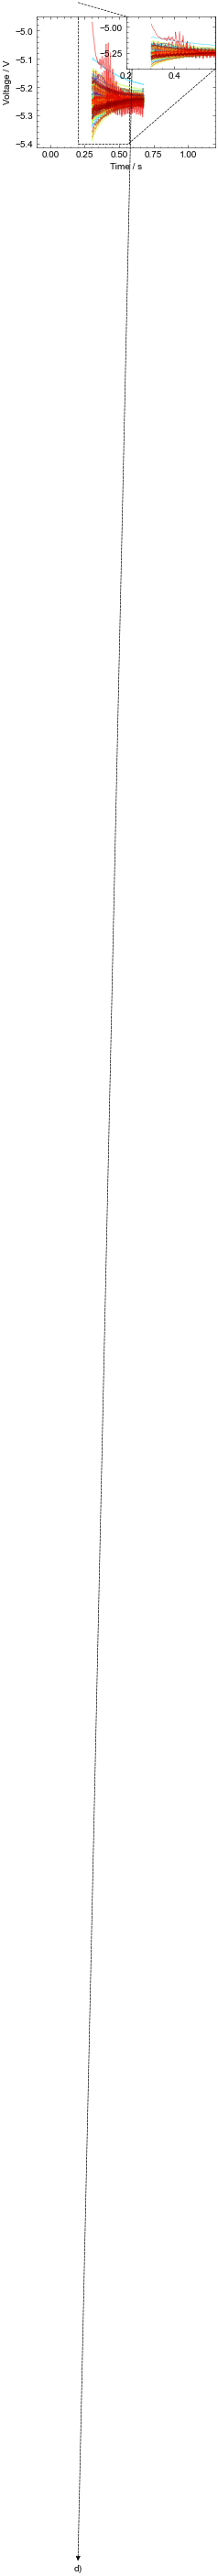

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("Time / s")
ax.set_ylabel("Voltage / V")
ax.set_xlim((-0.1, 1.2))

axins = ax.inset_axes([0.5, 0.6, 0.5, 0.4])
x1, x2, y1, y2 = 0.2, 0.57, -5.4, -4.9 # specify the limits delta: 370ms
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits


cmap = mpl.cm.jet
n_magnets = len(df_data.columns)
for i, d in enumerate(df_data.values.T[::-1]):
    ax.plot(df_data.index, d, c=cmap(i / n_magnets), alpha=0.5)
    axins.plot(df_data.index, d, c=cmap(i / n_magnets), alpha=0.8 ,linewidth=.5)
    
mark_inset(ax, axins, loc1=2, loc2=4, linestyle="--",linewidth=.7)
ax.annotate("a)", xy=(0, -6), xytext=(0, -14),
            arrowprops=dict(arrowstyle="<|-", linestyle="--",linewidth=.7, color="black"), ha="center")

ax.annotate("b)", xy=(0.03 , 5.7), xytext=(.2, 5.7),
            arrowprops=dict(arrowstyle="<|-", linestyle="--",linewidth=.7, color="black"), va="center", ha="center")

ax.annotate("c)", xy=(.1, -10), xytext=(.1, -14),
            arrowprops=dict(arrowstyle="<|-", linestyle="--",linewidth=.7, color="black"), ha="center")

ax.annotate("d)", xy=(.6, -5), xytext=(.2, -14),
            arrowprops=dict(arrowstyle="<|-", linestyle="--",linewidth=.7, color="black"), ha="center")

plt.savefig("paper_plots/u_mag.svg")

In [15]:
dataset_path_1EE = Path(r'D:\datasets\20230313_RBFPAPrimQuenchEEPlateau_V2')
dataset_creator_1EE = RBFPAPrimQuenchEEPlateau_V2()
ds1 = dataset_creator_1EE.load_dataset(fpa_identifiers=fpa_identifier,# mp3_fpa_df_unique.fpa_identifier.values,
                                       dataset_path=dataset_path_1EE)

f_lim = (0, 534)
f_window = np.hamming
ds_detrend = dataset_creator.detrend_dim(ds1, deg=-1)

da_fft = get_fft_of_DataArray(data=ds_detrend.data, f_lim=f_lim, f_window=f_window)
da_fft_amp = scale_fft_amplitude(data=da_fft, f_window=f_window)
da_fft_amp = da_fft_amp[:, :, da_fft_amp.frequency < f_lim[1]]

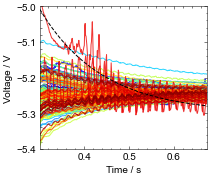

In [16]:
trend_idx = np.argsort(df_data.values[0])[::-1][1] # biggest init value
df_data = pd.DataFrame(ds1.data[0].values.T, columns=ds1.el_position.values, index=ds1.time.values)

fig, ax = plt.subplots(figsize=(3,2.625))
ax.set_xlabel("Time / s")
ax.set_ylabel("Voltage / V")
ax.set_xlim((df_data.index[0], df_data.index[-1]))
ax.set_ylim((-5.4, -5))

cmap = mpl.cm.jet
n_magnets = len(df_data.columns)
for i, d in enumerate(df_data.values.T[::-1]):
    ax.plot(df_data.index, d, c=cmap(i / n_magnets), alpha=0.8)
    if i == trend_idx:
        A, B, C = ds1.polyfit_coefficients.values[0,trend_idx]#2.53980872, 7.21418261, -5.29906925
        time = df_data.index
        x = A*np.exp(-(time)*B) + C
plt.plot(time, x, c='black', linestyle="--")

#plt.savefig("paper_plots/u_mag_zoom.svg")

In [17]:
def plot_position_frequency_map(ax, x_fft, frequency,
                                norm = colors.LogNorm, vmin=1e-5, vmax=1e-2, cmap=None):
    if norm is None:
        im = ax.imshow(x_fft.T,
                       extent=[1, 154, frequency.min(), frequency.max()],
                       aspect='auto',
                       vmin=vmin,
                       vmax=vmax,
                       origin='lower', 
                       cmap=cmap)
    else:
        im = ax.imshow(x_fft.T,
                       extent=[1, 154, frequency.min(), frequency.max()],
                       aspect='auto',
                       norm=norm(vmin=vmin, vmax=vmax),
                       origin='lower', 
                       cmap=cmap)
    plt.tight_layout()
    return im

# plot difference in reconstructions

In [18]:
event_idex = 49 #174 #

In [19]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle, Ellipse
cmrmap = plt.cm.get_cmap('CMRmap')
cmrmap_inverted = ListedColormap(cmrmap(np.linspace(1, 0, 256)))

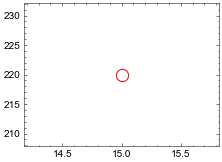

In [20]:
plt.scatter(15, 220, c='white', marker='o', s=150, facecolors='blue', edgecolors='r')

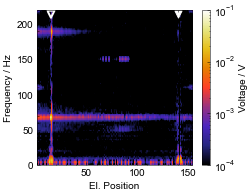

In [21]:
fig, ax = plt.subplots(figsize=(3.5,2.625))
im = plot_position_frequency_map(ax, np.nan_to_num(da_fft_amp.values), da_fft_amp.frequency, vmin=1e-4, vmax=1e-1, cmap="CMRmap")

ax.set_ylabel('Frequency / Hz')
ax.set_xlabel('El. Position')
cbar = fig.colorbar(im, ax=ax, fraction=0.2)
cbar.set_label('Voltage / V')
plt.ylim((0, 220))

plt.scatter(15, 214,  marker='v', s=50, facecolor='none', edgecolors='white', lw=2)
plt.scatter(140, 214, c='white', marker='v', s=50)

plt.savefig("paper_plots/u_mag_freq.svg")


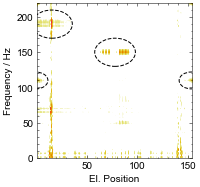

In [22]:
temp_path = "../output/nmf_sensitivity_all_events.py/full_sens_V3/hanning_20_mu_frobenius_nndsvda_False/"

df_components = pd.read_csv(temp_path + "components.csv", index_col="Unnamed: 0")
H = df_components.values.T
W = np.load(temp_path + "c_weights.npy")

fig, ax = plt.subplots(figsize=(3.5*0.8,2.625))
diff = abs(np.nan_to_num(da_fft_amp.values) - W[event_idex * 154:event_idex * 154 + 154] @ H)
im = plot_position_frequency_map(ax, diff, df_components.index.values, vmin=1e-4, vmax=1e-1, cmap=cmrmap_inverted)

#ax.set_ylabel(u'\u2248', rotation=0, fontsize=25, labelpad=20, va='baseline')
ax.set_ylabel('Frequency / Hz')
ax.set_xlabel('El. Position')
#cbar = fig.colorbar(im, ax=ax, fraction=0.2)
#cbar.set_label('Voltage / V')
plt.ylim((0, 220))

ax.add_patch(Circle((78, 150), 20, color="black", fill=False, linewidth=1, linestyle="dashed"))
#ax.add_patch(Circle((88,50),12, color="black", fill=False, linewidth=1, linestyle="dashed"))
ax.add_patch(Circle((16,190),20, color="black", fill=False, linewidth=1, linestyle="dashed"))

ax.add_patch(Circle((0,110),12, color="black", fill=False, linewidth=1, linestyle="dashed"))
ax.add_patch(Circle((153,110),12, color="black", fill=False, linewidth=1, linestyle="dashed"))

##plt.yticks([])

plt.savefig("paper_plots/diff_eu.svg")

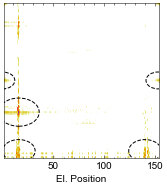

In [23]:
temp_path = "../output/nmf_sensitivity_all_events.py/full_sens_V3/hanning_20_mu_kullback-leibler_nndsvda_False/"

df_components = pd.read_csv(temp_path + "components.csv", index_col="Unnamed: 0")
H = df_components.values.T
W = np.load(temp_path + "c_weights.npy")

fig, ax = plt.subplots(figsize=(3.5*0.8,2.625))
diff = abs(np.nan_to_num(da_fft_amp.values) - W[event_idex * 154:event_idex * 154 + 154] @ H)


im = plot_position_frequency_map(ax, diff, df_components.index.values, vmin=1e-4, vmax=1e-1, cmap=cmrmap_inverted)

#ax.set_ylabel('Frequency / Hz')
ax.set_xlabel('El. Position')
#cbar = fig.colorbar(im, ax=ax, fraction=0.2)
#cbar.set_label('Voltage / V')
plt.ylim((0, 220))

ax.add_patch(Circle((140, 10), 16, color="black", fill=False, linewidth=1, linestyle="dashed"))
ax.add_patch(Circle((16, 10), 16, color="black", fill=False, linewidth=1, linestyle="dashed"))
ax.add_patch(Circle((16,65),20, color="black", fill=False, linewidth=1, linestyle="dashed"))

ax.add_patch(Circle((0,110),12, color="black", fill=False, linewidth=1, linestyle="dashed"))
ax.add_patch(Circle((153,110),12, color="black", fill=False, linewidth=1, linestyle="dashed"))

plt.yticks([])
plt.savefig("paper_plots/diff_kl.svg")

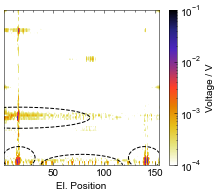

In [24]:
temp_path = "../output/nmf_sensitivity_all_events.py/full_sens_V3_IS/hanning_20_mu_itakura-saito_nndsvda_False/"

df_components = pd.read_csv(temp_path + "components.csv", index_col="Unnamed: 0")
H = df_components.values.T
W = np.load(temp_path + "c_weights.npy")

fig, ax = plt.subplots(figsize=(3.5,2.625))
diff = abs(np.nan_to_num(da_fft_amp.values) - W[event_idex * 154:event_idex * 154 + 154] @ H)
#diff[diff<0] = 1e-5

im = plot_position_frequency_map(ax, diff, df_components.index.values, vmin=1e-4, vmax=1e-1, cmap=cmrmap_inverted)

ax.add_patch(Circle((140, 10), 16, color="black", fill=False, linewidth=1, linestyle="dashed"))
ax.add_patch(Circle((16, 10), 16, color="black", fill=False, linewidth=1, linestyle="dashed"))
ax.add_patch(Ellipse((16, 67), 140, 30, color="black", fill=False, linewidth=1, linestyle="dashed"))

ax.add_patch(Ellipse((78, 0), 80, 30, color="black", fill=False, linewidth=1, linestyle="dashed"))

#ax.add_patch(Circle((78, 150), 20, color="white", fill=True, linewidth=1, linestyle="dashed"))
#ax.add_patch(Circle((0,110), 12, color="white", fill=True, linewidth=1, linestyle="dashed"))
#ax.add_patch(Circle((153,110), 12, color="white", fill=True, linewidth=1, linestyle="dashed"))

#ax.set_ylabel('Frequency / Hz')
ax.set_xlabel('El. Position')
cbar = fig.colorbar(im, ax=ax, fraction=0.2)
cbar.set_label('Voltage / V')
plt.ylim((0, 220))
plt.yticks([])
plt.savefig("paper_plots/diff_is.svg")

# Plot Components

([], [])

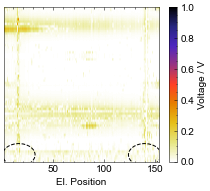

In [25]:
event_example = np.load("../data/final_components/event_example.npy")
frequency = np.load("../data/final_components/frequency_example.npy")

W = np.load("../data/final_components/cweights_fitted.npy") 
H = np.load("../data/final_components/weights_fitted.npy")
event_idex =47
#W = W_all[event_idex * 154:event_idex * 154 + 154]

fig, ax = plt.subplots(figsize=(3.5,2.625))
diff = abs(event_example - W[event_idex * 154:event_idex * 154 + 154] @ H) # 
#diff[diff<0] = 1e-5

im = plot_position_frequency_map(ax, diff, frequency , norm=None, vmin=0, vmax=1, cmap=cmrmap_inverted)

ax.add_patch(Circle((140, 10), 16, color="black", fill=False, linewidth=1, linestyle="dashed"))
ax.add_patch(Circle((16, 10), 16, color="black", fill=False, linewidth=1, linestyle="dashed"))
#ax.add_patch(Ellipse((16, 67), 140, 30, color="black", fill=False, linewidth=1, linestyle="dashed"))

#ax.add_patch(Ellipse((78, 0), 80, 30, color="black", fill=False, linewidth=1, linestyle="dashed"))

#ax.add_patch(Circle((78, 150), 20, color="white", fill=True, linewidth=1, linestyle="dashed"))
#ax.add_patch(Circle((0,110), 12, color="white", fill=True, linewidth=1, linestyle="dashed"))
#ax.add_patch(Circle((153,110), 12, color="white", fill=True, linewidth=1, linestyle="dashed"))

#ax.set_ylabel('Frequency / Hz')
ax.set_xlabel('El. Position')
cbar = fig.colorbar(im, ax=ax, fraction=0.2)
cbar.set_label('Voltage / V')

plt.ylim((0, 220))
plt.yticks([])


#plt.savefig("paper_plots/diff_is.svg")

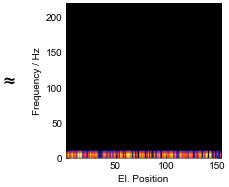

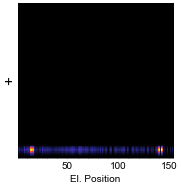

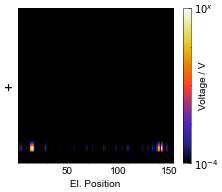

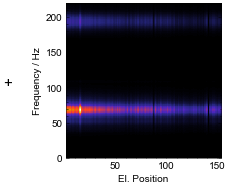

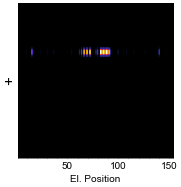

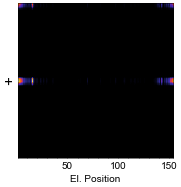

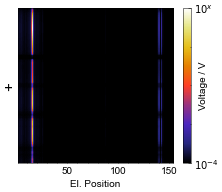

In [26]:
component_indexes_1EE = [0,1,3,4,2,6,5]

event_idex =47
for k, i in enumerate(component_indexes_1EE):
    
    
    if (k == len(component_indexes_1EE)-1) | (k == 2):
        fig, ax = plt.subplots(figsize=(3.5,2.625))
    else:
        fig, ax = plt.subplots(figsize=(3.5*0.8,2.625))

    W_temp = W[event_idex * 154:event_idex * 154 + 154, i:i + 1]
    H_temp = H[i:i + 1]
    data_reconstructed = W_temp @ H_temp
    
    
    
    im = plot_position_frequency_map(ax, data_reconstructed, da_fft_amp.frequency, norm=None, vmin=0, vmax=data_reconstructed.max(), cmap="CMRmap")
    
    if k == 0:
        #im = plot_position_frequency_map(ax, data_reconstructed, da_fft_amp.frequency, norm=None, vmin = 0, vmax = 1.2, cmap="CMRmap")
        ax.text(-60,100, u'\u2248', fontsize=20)
        ax.set_ylabel('Frequency / Hz') #, fontsize=12
        
    elif (k == len(component_indexes_1EE)-1) | (k == 2):
        cbar = fig.colorbar(im, ax=ax, fraction=0.2)
        cbar.set_ticks([0,data_reconstructed.max()])
        cbar.set_ticklabels(["$10^{-4}$", "$10^x$"])
        cbar.set_label('Voltage / V', labelpad=-20)
        ax.set_yticks([])
        ax.set_ylabel("+", fontsize=15, labelpad=0) # va='baseline'
    elif k== 3:
        ax.text(-60,100, '+', fontsize=15)
        ax.set_ylabel('Frequency / Hz')
        #ax.set_ylabel("+", fontsize=15, labelpad=0)
    else:
        ax.set_yticks([])
        ax.set_ylabel("+", fontsize=15, labelpad=0) # va='baseline'
    
    ax.set_ylim((0, 220))
    ax.set_xlabel('El. Position') #, fontsize=12
    #ax.tick_params(axis='both', which='major', labelsize=12)
    
    #print(f"{np.log10(dataset_creator.exp_scale_data(data_reconstructed.max(), vmin = 1e-4, vmax = 1e-1)):.2f}")
    plt.savefig(f"paper_plots/component_{k+1}_example.svg")

In [27]:
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'

In [28]:
2.625/0.625

4.2

(3, 159)


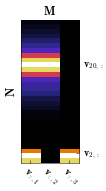

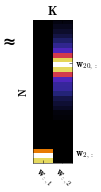

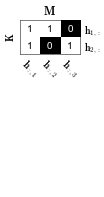

In [34]:
from matplotlib import pyplot as plt, colors

event_idex = 47
signals_idex = np.array([14,50,139])
# (event_idex*154)
i = 0
W_temp = W[signals_idex+(event_idex*154)].T[[0,4]].T

W_temp = np.array(((1,1),(0,1),(1,0)))
H_temp = H[[0,4]]
data_reconstructed = W_temp @ H_temp
print(data_reconstructed.shape)

ylim = 100
'''

fig, ax = plt.subplots(figsize=(3.5*0.3,2.625))

im = ax.imshow(da_fft_amp.values[:,signals_idex].T,
               extent=[0, 3, frequency.min(), frequency.max()],
               aspect='auto',
               norm = colors.LogNorm(vmin=1e-4, vmax=1e-1),
               origin='lower',
               cmap="CMRmap",
               interpolation=None)

ax.set_ylabel("Frequency / Hz")
ax.set_ylim((0,ylim))

'''

fig, ax = plt.subplots(figsize=(3.5*0.3,2.625))
im = ax.imshow(data_reconstructed.T,
               extent=[0, 6, frequency.min(), frequency.max()],
               aspect='auto',
               vmin=0,
               vmax=1,
               origin='lower',
               cmap="CMRmap",
               interpolation=None)

ax.set_ylim((0, ylim))
plt.title('$\mathbf{M}$', fontsize=12)
ax.set_ylabel("$\mathbf{N}$", fontsize=12)

ax.set_yticks([7,69.5])
ax.set_yticks([], minor=True)
ax.set_yticklabels(["$\mathbf{v}_{2,:}$","$\mathbf{v}_{20,:}$"])
ax.yaxis.tick_right()

ax.set_xticks([1,3,5], minor=False)
ax.set_xticks([], minor=True)
ax.set_xticklabels(["$\mathbf{v}_{:,1}$","$\mathbf{v}_{:,2}$","$\mathbf{v}_{:,3}$"], rotation=-45)

plt.savefig(f"paper_plots/V_toy.svg")

fig, ax = plt.subplots(figsize=(3.5*0.2,2.625))
im = ax.imshow(H_temp.T,
               extent=[0, 2, frequency.min(), frequency.max()],
               aspect='auto',
               vmin=0,
               vmax=1,
               origin='lower',
               cmap="CMRmap",
               interpolation=None)

ax.set_ylim((0, ylim))
plt.title('$\mathbf{K}$', fontsize=12)
ax.set_ylabel("$\mathbf{N}$")

ax.set_yticks([7,69.5])
ax.set_yticks([], minor=True)
ax.set_yticklabels(["$\mathbf{w}_{2,:}$","$\mathbf{w}_{20,:}$"])
ax.yaxis.tick_right()

ax.set_xticks([0.5,1.5], minor=False)
ax.set_xticks([], minor=True)
ax.set_xticklabels(["$\mathbf{w}_{:,1}$","$\mathbf{w}_{:,2}$"], rotation=-45)

ax.text(-1.5,80, u'\u2248', fontsize=20)
plt.savefig(f"paper_plots/W_toy.svg")


fig, axes = plt.subplots(2,1, figsize=(3.5*0.31,2.625), gridspec_kw={'height_ratios': [1.5, 4.2]})
ax=axes[0]
ax2=axes[1]

im = ax.imshow(W_temp.T,
               aspect='auto',
               vmin=0,
               vmax=1,
               origin='lower',
               cmap="CMRmap",
               interpolation=None)

ax.set_title('$\mathbf{M}$', fontsize=12)
ax.set_ylabel("$\mathbf{K}$")

ax.set_yticks([0,1])
ax.set_yticks([], minor=True)
ax.set_yticklabels(["$\mathbf{h}_{2,:}$","$\mathbf{h}_{1,:}$"])
ax.yaxis.tick_right()
ax.set_xticks([0,1,2], minor=False)
ax.set_xticks([], minor=True)
ax.set_xticklabels(["$\mathbf{h}_{:,1}$","$\mathbf{h}_{:,2}$","$\mathbf{h}_{:,3}$"], rotation=-45)
ax.tick_params(axis='both', which='major', length=0, width=0)

ax2.set_yticks([0,1], c="white")
ax2.set_yticks([], minor=True)
ax2.set_yticklabels(["$\mathbf{h}_{2,:}$","$\mathbf{h}_{1,:}$"], c="white")
ax2.yaxis.tick_right()
ax2.set_xticks([0,1,2], minor=False, c="white")
ax2.set_xticks([], minor=True)
ax2.set_xticklabels(["$\mathbf{vh}_{:,1}$","$\mathbf{vh}_{:,2}$","$\mathbf{vh}_{:,3}$"], rotation=-45, c="white")
ax2.tick_params(axis='both', which='major', length=0, width=0)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_zorder(-1)


for (j,i),label in np.ndenumerate(W_temp):
    if label ==1:
        ax.text(j, i, label, ha='center', va='center', color='black')
    else:
        ax.text(j, i, label, ha='center', va='center', color='white')
plt.savefig(f"paper_plots/H_toy.svg")

# 3D Plot

In [32]:
def roll_points(X, Y, Z, roll_angle):
    """Roll the points by the given roll_angle."""
    roll_rad = np.deg2rad(roll_angle)
    cos_roll = np.cos(roll_rad)
    sin_roll = np.sin(roll_rad)
    
    X_rot = X * cos_roll - Z * sin_roll
    Z_rot = X * sin_roll + Z * cos_roll
    
    return X_rot, Y, Z_rot

TypeError: view_init() got an unexpected keyword argument 'roll'

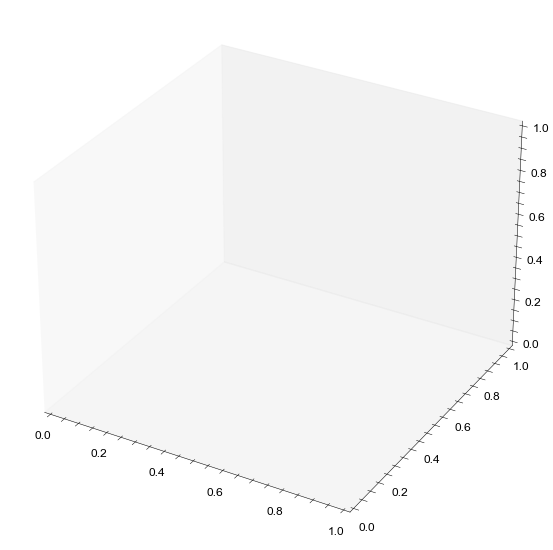

In [33]:
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

component_indexes_1EE = [0,1,3,4,2,6,5]

event_idex =47

# Set the z coordinates for each image
z_coords = np.arange(7)

# Define the X and Y coordinates for the images
x = np.arange(data_reconstructed.shape[1])
y = np.arange(data_reconstructed.shape[0])
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

images = []
for k, i in enumerate(component_indexes_1EE):
    Z = np.ones_like(X) * z_coords[k] 

    W_temp = W[event_idex * 154:event_idex * 154 + 154, i:i + 1]
    H_temp = H[i:i + 1]
    data_reconstructed = W_temp @ H_temp
    
    im = plot_position_frequency_map(ax, data_reconstructed, da_fft_amp.frequency, norm=None, vmin=None, vmax=None, cmap="CMRmap")
    images.append(im)

plt.close()  # Close the current figure

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# Set the x coordinates for each image
x_coords = np.arange(7)

# Define the X and Y coordinates for the images
z = np.arange(data_reconstructed.shape[1])
y = np.arange(data_reconstructed.shape[0])
Z, Y = np.meshgrid(z, y)

# Remove grid lines
ax.grid(False)

# Set the view angle so the X-axis is vertical
ax.view_init(elev=30, azim=-45, roll=30)

for i, image in enumerate(images):
    X = np.nan_to_num(np.ones_like(Z) * x_coords[i])  # Set the X coordinate for the current image
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=image.get_array().reshape(data_reconstructed.shape + (1,)).repeat(3, -1), shade=False)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

# P-Value Boxplot

In [54]:
path = "../output/nmf_sensitivity.py/full_sens/"
file_name = "p_values.csv"
df_p_values = pd.read_csv(path + file_name)

In [55]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])

Lower whisker value for the first box: 0.0
Upper whisker value for the first box: 2.143451749425651e-09


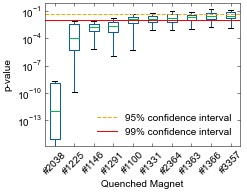

In [61]:
n_outliers = 10
drop_colums = df_p_values.filter(regex = 'itakura-saito').columns.values
a_columns = ['fpa_identifier', 'median', 'std']

magnets = mp3_fpa_df_unique.set_index('fpa_identifier', drop=True).loc[df_p_values.fpa_identifier, 'Short magnet ID'].astype(int).values
mid = [f"#{m}" for m in magnets[:n_outliers]]
df_p_values = df_p_values.set_index(magnets, drop=True)
    
df_p_values['median'] = df_p_values.drop(columns=a_columns + list(drop_colums)).median(axis=1)
df_p_values['std'] = df_p_values.drop(columns=a_columns + list(drop_colums)).std(axis=1)
df_p_values = df_p_values.sort_values(by='median')

plt.figure() #(3.5,2.625*2)) #
bp = df_p_values.drop(columns=a_columns + list(drop_colums)).head(n_outliers).T.boxplot(showfliers=False, grid = False, return_type='dict')
plt.xticks(range(1, len(mid) + 1), mid)
plt.xlabel('Quenched Magnet')
plt.ylabel('p-value')
plt.axhline(y=0.05, color='orange', linestyle='--', label='95% confidence interval')
plt.axhline(y=0.01, color='r', linestyle='-', label='99% confidence interval')
plt.legend()
#plt.title('Outliers sorted by p-value')
plt.yscale('log')
plt.minorticks_off()
plt.xticks(rotation=45)


# Getting whiskers' values for the first box
whiskers = [whisker.get_ydata() for whisker in bp['whiskers']]
first_box_lower_whisker = whiskers[0][1]
first_box_upper_whisker = whiskers[1][1]

print(f"Lower whisker value for the first box: {first_box_lower_whisker}")
print(f"Upper whisker value for the first box: {first_box_upper_whisker}")


plt.savefig("paper_plots/outliers.svg")

In [58]:
a_columns + list(drop_colums)

['fpa_identifier',
 'median',
 'std',
 '0_ones_2_mu_itakura-saito_nndsvda_False',
 '0_hanning_2_mu_itakura-saito_nndsvda_False',
 '0_bartlett_2_mu_itakura-saito_nndsvda_False',
 '0_blackman_2_mu_itakura-saito_nndsvda_False',
 '0_flattop_2_mu_itakura-saito_nndsvda_False',
 '0_hamming_2_mu_itakura-saito_nndsvda_False',
 '0_tukey_2_mu_itakura-saito_nndsvda_False',
 '1_ones_2_mu_itakura-saito_nndsvda_False',
 '1_hanning_2_mu_itakura-saito_nndsvda_False',
 '1_bartlett_2_mu_itakura-saito_nndsvda_False',
 '1_blackman_2_mu_itakura-saito_nndsvda_False',
 '1_flattop_2_mu_itakura-saito_nndsvda_False',
 '1_hamming_2_mu_itakura-saito_nndsvda_False',
 '1_tukey_2_mu_itakura-saito_nndsvda_False',
 '0_ones_3_mu_itakura-saito_nndsvda_False',
 '0_hanning_3_mu_itakura-saito_nndsvda_False',
 '0_bartlett_3_mu_itakura-saito_nndsvda_False',
 '0_blackman_3_mu_itakura-saito_nndsvda_False',
 '0_flattop_3_mu_itakura-saito_nndsvda_False',
 '0_hamming_3_mu_itakura-saito_nndsvda_False',
 '0_tukey_3_mu_itakura-saito_

# Chose n-components

In [3]:
df_results = pd.read_csv("comp_weight_anlysis3.csv")

In [4]:
df_results

,n_components,beta_loss,f_window,weights_cosine,weights_euclidean,weights_sqeuclidean,weights_seuclidean,weights_correlation,weights_jensenshannon,weights_chebyshev,...,weights_norm_chebyshev,weights_norm_canberra,comp_norm_cosine,comp_norm_euclidean,comp_norm_sqeuclidean,comp_norm_seuclidean,comp_norm_correlation,comp_norm_jensenshannon,comp_norm_chebyshev,comp_norm_canberra
0,2.0,frobenius,ones,0.119803,0.003254,0.000097,0.731939,0.812988,inf,0.003062,...,0.349846,0.551344,0.055306,0.244233,0.110613,1.472906,0.852161,0.099207,0.196906,0.279248
1,2.0,frobenius,hanning,0.168924,0.003273,0.000154,0.937155,0.996099,inf,0.003992,...,0.419448,0.628017,0.060653,0.254663,0.121305,1.458101,0.512563,0.111437,0.213711,0.313811
2,2.0,frobenius,bartlett,0.163288,0.003824,0.000098,0.860726,0.979198,inf,0.003245,...,0.392232,0.608071,0.060140,0.254595,0.120280,1.463511,0.526533,0.110760,0.213468,0.312266
3,2.0,frobenius,blackman,0.174447,0.004242,0.000602,0.760898,0.999027,inf,0.004193,...,0.408581,0.674212,0.061973,0.252437,0.123945,1.430132,0.469447,0.113252,0.214041,0.319262
4,2.0,frobenius,flattop,0.188937,0.004220,0.000186,0.624423,0.986245,inf,0.004270,...,0.414384,0.704042,0.064627,0.243835,0.129254,1.350511,0.244322,0.118510,0.211692,0.338668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,20.0,itakura-saito,bartlett,0.514037,0.004885,0.000116,3.294453,0.942600,0.464404,0.004417,...,0.591951,11.257002,0.542837,0.965419,1.085674,5.769808,0.706858,0.508325,0.623719,12.877519
395,20.0,itakura-saito,blackman,0.483250,0.006325,0.000131,3.734775,0.908727,0.449738,0.002761,...,0.557863,10.794678,0.566995,0.988479,1.133991,5.680388,0.702002,0.527624,0.672662,12.888974
396,20.0,itakura-saito,flattop,0.461234,0.006374,0.000122,2.480873,0.915206,0.442855,0.004337,...,0.532745,10.733608,0.650200,1.078308,1.300399,5.939919,0.781664,0.590325,0.728917,13.669410
397,20.0,itakura-saito,hamming,0.486686,0.004690,0.000255,3.330329,0.924015,0.456739,0.003977,...,0.570287,10.798441,0.535111,0.953560,1.070223,5.701921,0.696698,0.501451,0.620353,12.640335


In [5]:
for w in df_results.beta_loss.unique():
    print(w, df_results[(df_results.beta_loss ==w) & (df_results.n_components==7)].sort_values(by="comp_chebyshev")["f_window"].values[0])

frobenius ones
kullback-leibler ones
itakura-saito ones


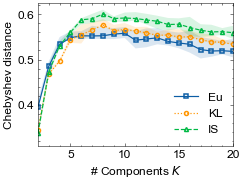

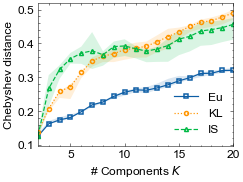

In [11]:
df_results = pd.read_csv("comp_weight_anlysis3.csv")

p_measures = ['weights_norm_chebyshev','comp_chebyshev']
p_measure_names = ["Chebyshev distance", "Chebyshev distance"]

dist_measures = ['frobenius', 'kullback-leibler', 'itakura-saito']
dist_measures_name = ['Eu', 'KL', 'IS']
linestyle = ["solid","dotted","dashed"]
markers = ["s","o","^"]

for j, p in enumerate(p_measures):
    fig, ax = plt.subplots()
    for i, loss in enumerate(dist_measures):
        if (loss == 'frobenius') & (p=='comp_chebyshev'):
            df = df_results[df_results.beta_loss ==loss].groupby(["n_components"]).median()[p]
        else: 
            df = df_results[df_results.beta_loss ==loss].groupby(["n_components"]).mean()[p]
        y = df.values
        x = df.index

        q1 = df_results[df_results.beta_loss ==loss].groupby(["n_components"]).quantile(0.25)[p].values
        
        q3 = df_results[df_results.beta_loss ==loss].groupby(["n_components"]).quantile(0.75)[p].values

        ax.plot(x,y,'-', label = dist_measures_name[i], ls=linestyle[i], lw=1.2, marker=markers[i], markerfacecolor="None", ms=4, markeredgewidth=1.5)
        
        ax.set_ylabel(p_measure_names[j], fontsize=12)
        ax.set_xlabel("# Components $K$", fontsize=12)
        plt.legend()
        ax.fill_between(x, q1, q3, alpha=.15)

    
    plt.xlim((2,20))
    plt.savefig(f"paper_plots/{p}.svg")

# Compare distance function

In [15]:
# Calculate Itakura-Saito divergence
def euclidean_dist(a,b):
    return (a-b)**2

# Calculate Itakura-Saito divergence
def kl_divergence(a,b):
    return a*np.log(a/b)-a+b

# Calculate Itakura-Saito divergence
def itakura_saito_divergence(a,b):
    return a/b-np.log(a/b)-1

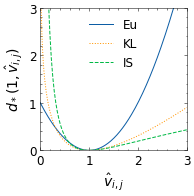

In [16]:
# Define sample data points
x_hat = np.linspace(0, 3, 200)
x = 1

# Calculate Euclidean distance
eu_dist = [euclidean_dist(x, x_p) for x_p in x_hat]

is_divergence = [itakura_saito_divergence(x, x_p) for x_p in x_hat]

# Calculate KL divergence
kl_div = [kl_divergence(x, x_p) for x_p in x_hat]

# Plot comparison
labels = ['Eu', 'KL', 'IS']
values = [eu_dist, kl_div, is_divergence]
linestyle = ["solid","dotted","dashed"]

plt.figure(figsize=(2.625, 2.625))
for v, l, ls in zip(values, labels, linestyle):
    plt.plot(x_hat, v, label=l, linestyle=ls)
plt.legend()
plt.ylim((0,3))
plt.xlim((0,3))

plt.xlabel("$\hat{v}_{i,j}$")
plt.ylabel("$d_*(1,\hat{v}_{i,j})$")

plt.savefig("paper_plots/dist_measures.svg")
plt.show()

In [8]:
euclidean_dist(1, 2), euclidean_dist(100, 101), kl_divergence(1, 2), kl_divergence(100, 108.039), itakura_saito_divergence(1, 2), itakura_saito_divergence(100, 200)

(-3,
 -201,
 -1.3010299956639813,
 -11.397055574040593,
 -0.19897000433601875,
 -0.19897000433601875)

In [9]:
euclidean_dist(9, 10), euclidean_dist(900,901), kl_divergence(9, 10), kl_divergence(900, 909.68), itakura_saito_divergence(9, 10), itakura_saito_divergence(900, 1000)

(-19,
 -1801,
 -1.4118174150460767,
 -13.861523376589389,
 -0.05424250943932485,
 -0.05424250943932485)

In [ ]:
from scipy.special import lambertw

# Calculate Itakura-Saito divergence
def euclidean_dist(a):
    return a-1

# Calculate Itakura-Saito divergence
def kl_divergence(a):
    return -a*lambertw(-np.exp(-1-2/a))

# Calculate Itakura-Saito divergence
def itakura_saito_divergence(a):
    return -a/lambertw(-1/np.exp(2))

In [9]:
euclidean_dist(1, 2), euclidean_dist(100, 101), kl_divergence(1, 2), kl_divergence(100, 108.039), itakura_saito_divergence(1, 2), itakura_saito_divergence(100, 200)

-1.0

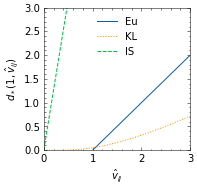

In [102]:
# Define sample data points
x_hat = np.linspace(0, 3, 200)

# Calculate Euclidean distance
eu_dist = [euclidean_dist(x_p) for x_p in x_hat]

is_divergence = [itakura_saito_divergence(x_p) for x_p in x_hat]

# Calculate KL divergence
kl_div = [kl_divergence(x_p) for x_p in x_hat]

# Plot comparison
labels = ['Eu', 'KL', 'IS']
values = [eu_dist, kl_div, is_divergence]
linestyle = ["solid","dotted","dashed"]

plt.figure(figsize=(2.625, 2.625))
for v, l, ls in zip(values, labels, linestyle):
    plt.plot(x_hat, v, label=l, linestyle=ls)
plt.legend()
plt.ylim((0,3))
plt.xlim((0,3))

plt.xlabel("$\hat{v}_{ij}$")
plt.ylabel("$d_*(1,\hat{v}_{ij})$")

plt.savefig("paper_plots/dist_measures.svg")
plt.show()

# Sum up compontents

In [56]:
# Initialize an empty list to store the loaded arrays
arrays = []

n_components = [5]#[2,3,4,5,6,8,9,10,11,12,13,14,15]

# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(path):
    for file in files:
        for n in n_components:
            
            # Check if the file has a .npy extension
            if file.endswith('.csv') & (f'_{n}_mu' in root):
                print(root, file)
                # Load the array from the file and append it to the list
                df = pd.read_csv(os.path.join(root, file), index_col='Unnamed: 0')
                arrays.append(df.values)
                
X = np.hstack(arrays)
kmeans = KMeans(n_clusters=int(arrays[0].shape[-1])).fit(X.T)

../output/nmf_sensitivity_all_events.py/full_sens_V2/bartlett_5_mu_frobenius_nndsvda_False components.csv
../output/nmf_sensitivity_all_events.py/full_sens_V2/bartlett_5_mu_kullback-leibler_nndsvda_False components.csv
../output/nmf_sensitivity_all_events.py/full_sens_V2/blackman_5_mu_frobenius_nndsvda_False components.csv
../output/nmf_sensitivity_all_events.py/full_sens_V2/blackman_5_mu_kullback-leibler_nndsvda_False components.csv
../output/nmf_sensitivity_all_events.py/full_sens_V2/flattop_5_mu_frobenius_nndsvda_False components.csv
../output/nmf_sensitivity_all_events.py/full_sens_V2/flattop_5_mu_kullback-leibler_nndsvda_False components.csv
../output/nmf_sensitivity_all_events.py/full_sens_V2/hamming_5_mu_frobenius_nndsvda_False components.csv
../output/nmf_sensitivity_all_events.py/full_sens_V2/hamming_5_mu_kullback-leibler_nndsvda_False components.csv
../output/nmf_sensitivity_all_events.py/full_sens_V2/hanning_5_mu_frobenius_nndsvda_False components.csv
../output/nmf_sensitivi

In [57]:
#pd.DataFrame(kmeans.cluster_centers_.T, df.index, df.columns).to_csv('kmeans_components.csv')

In [58]:
df_components = pd.read_csv("../data/1EE_final_components_V2/kmeans_components.csv", index_col="Unnamed: 0")

In [59]:
df_components = df_components / df_components.max()

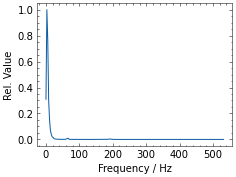

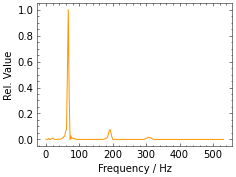

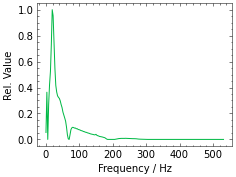

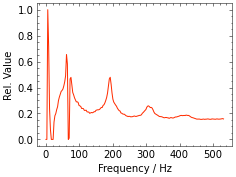

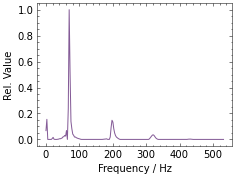

In [83]:
compontents = df_components.columns#['component_4', 'component_0', 'component_2', 'component_3', 'component_1']

colors = ['#0C5DA5', '#FF9500', '#00B945', '#FF2C00', '#845B97', '#474747', '#9e9e9e']

for i, component in enumerate(compontents):
    fig, ax = plt.subplots()
    ax.plot(df_components[component].index, df_components[component].values, c=colors[i])
    ax.set_ylabel("Rel. Value")
    ax.set_xlabel("Frequency / Hz")
    
    #ax.set_xlim((0, 320))
    plt.savefig(f"paper_plots/component_{i}.svg")

In [86]:
path = "../output/nmf_sensitivity_all_events.py/full_sens_V2/" 
file_name = "result.csv"
df_loss = pd.read_csv(path + file_name)
df_loss[df_loss["n_components"]==15].sort_values(by="Loss")#.plot(x='coph_corr', y='Loss')

,Unnamed: 0,f_window,n_components,solver,beta_loss,init,shuffle,Loss,L2_C,L2_C_norm,coph_corr
77,77,hamming,15,mu,frobenius,nndsvda,False,1.265971,49.851561,183.831454,0.752022
38,38,bartlett,15,mu,frobenius,nndsvda,False,1.291566,49.680301,182.651311,0.871795
90,90,tukey,15,mu,frobenius,nndsvda,False,1.302520,49.567452,178.130839,0.776159
25,25,hanning,15,mu,frobenius,nndsvda,False,1.306466,49.833930,166.481251,0.956924
51,51,blackman,15,mu,frobenius,nndsvda,False,1.316288,52.912348,191.667456,0.956143
12,12,ones,15,mu,frobenius,nndsvda,False,1.351094,48.740500,190.135000,0.831586
142,142,blackman,15,mu,kullback-leibler,nndsvda,False,1.449211,70.138042,150.461109,0.764849
116,116,hanning,15,mu,kullback-leibler,nndsvda,False,1.467507,65.886164,142.618111,0.835252
103,103,ones,15,mu,kullback-leibler,nndsvda,False,1.485526,62.033272,158.232948,0.820527
64,64,flattop,15,mu,frobenius,nndsvda,False,1.516610,66.898518,202.303267,0.962463


In [62]:
path = "../output/nmf_sensitivity_all_events.py/kmeans_components/" 
file_name = "result.csv"
df_loss = pd.read_csv(path + file_name)
df_loss.sort_values(by="coph_corr")

,Unnamed: 0,f_window,n_components,solver,beta_loss,init,shuffle,Loss,L2_C,L2_C_norm,coph_corr
7,7,ones,5,mu,kullback-leibler,nndsvda,False,4.236449,108.867539,130.84645,0.984177
13,13,tukey,5,mu,kullback-leibler,nndsvda,False,4.473201,108.867539,130.84645,0.995685
11,11,flattop,5,mu,kullback-leibler,nndsvda,False,7.639369,108.867539,130.84645,0.996684
0,0,ones,5,mu,frobenius,nndsvda,False,3.751350,108.867539,130.84645,0.996853
9,9,bartlett,5,mu,kullback-leibler,nndsvda,False,4.615420,108.867539,130.84645,0.997879
8,8,hanning,5,mu,kullback-leibler,nndsvda,False,4.822745,108.867539,130.84645,0.997929
10,10,blackman,5,mu,kullback-leibler,nndsvda,False,5.061525,108.867539,130.84645,0.997953
12,12,hamming,5,mu,kullback-leibler,nndsvda,False,4.635460,108.867539,130.84645,0.997967
4,4,flattop,5,mu,frobenius,nndsvda,False,5.914196,108.867539,130.84645,0.999192
6,6,tukey,5,mu,frobenius,nndsvda,False,3.503781,108.867539,130.84645,0.999322


# Reconstruct event

In [134]:
# Choose event with low loss
df_loss = pd.read_csv("../output/nmf_sensitivity_all_events.py/full_sens_V3/loss.csv")
df_temp = df_loss[["fpa_identifier","hamming_20_mu_kullback-leibler_nndsvda_False"]].sort_values(by="hamming_20_mu_kullback-leibler_nndsvda_False").reset_index()
df_temp[df_temp.fpa_identifier == "RB_RB.A78_1617123458120000000"]

,index,fpa_identifier,hamming_20_mu_kullback-leibler_nndsvda_False
728,746,RB_RB.A78_1617123458120000000,0.008348
997,47,RB_RB.A78_1617123458120000000,0.011600


In [143]:
temp_path = "../output/nmf_sensitivity_all_events.py/full_sens_V3/hamming_20_mu_kullback-leibler_nndsvda_False/"
#temp_path = "../output/nmf_sensitivity_all_events.py/2023-04-27T15.02.00.415643/hamming_20_mu_itakura-saito_nndsvda_False/"
df_components = pd.read_csv(temp_path + "components.csv", index_col="Unnamed: 0")
H = df_components.values.T
W = np.load(temp_path + "c_weights.npy")
event_idex = 49
print(W.shape, H.shape)

(215292, 20) (20, 200)


KeyboardInterrupt: 

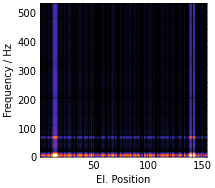

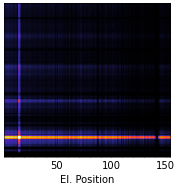

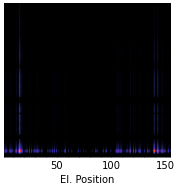

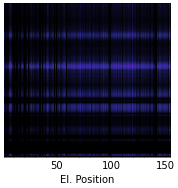

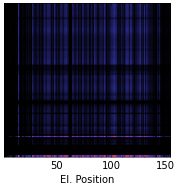

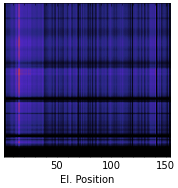

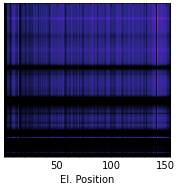

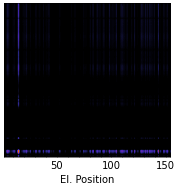

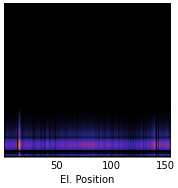

In [140]:
for k, i in enumerate(np.arange(len(H))):
    fig, ax = plt.subplots(figsize=(3,2.625))
    if isinstance(i, list):
        W_temp = 0
        H_temp = 0
        for j in i:
            W_temp += W[event_idex * 154:event_idex * 154 + 154, j:j + 1]
            H_temp += H[j:j + 1]
        H_temp /= len(i)  # sum components, mean weight, or other way around
    else:
        W_temp = W[event_idex * 154:event_idex * 154 + 154, i:i + 1]
        H_temp = H[i:i + 1]
        
    data_reconstructed = W_temp @ H_temp
    im = plot_position_frequency_map(ax, data_reconstructed+1e-5, df_components.index, vmin=1e-5, vmax=1e-2, cmap='CMRmap')
    
    if i == 0:
        ax.set_ylabel('Frequency / Hz')
    else:
        ax.set_yticks([])
    ax.set_xlabel('El. Position')
    #ax[k].set_title(f'Component {k}')
    #ax.set_ylim((0, 270))
    plt.savefig(f"paper_plots/example_{i}.svg")

# Analyze component weights

In [3]:
mp3_fpa_df = pd.read_csv("../data/MP3_context_data/20230313_RB_processed.csv")
snapshot_context_df = pd.read_csv("../data/RB_snapshot_context.csv")
loss = pd.read_csv("../output/nmf_sensitivity_all_events.py/kmeans_components/loss.csv")

mp3_fpa_df = pd.concat([mp3_fpa_df, snapshot_context_df])
fpa_with_result = loss.drop_duplicates(subset=['fpa_identifier']).fpa_identifier.values
mp3_fpa_df = mp3_fpa_df[mp3_fpa_df.fpa_identifier.isin(fpa_with_result)]
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])

In [42]:
path = "../output/nmf_sensitivity_all_events.py/kmeans_components/"

# Initialize an empty list to store the loaded arrays
arrays = []

n_components = [5]#[2,3,4,5,6,8,9,10,11,12,13,14,15]
# Walk through the directory and its subdirectories
for root, dirs, files in os.walk(path):
    for file in files:
        for n in n_components:
            
            # Check if the file has a .npy extension
            if file.endswith('.npy') & (f'_{n}_mu' in root):
                print(root, file)
                # Load the array from the file and append it to the list
                npy = np.load(os.path.join(root, file))
                n_magnets = 154
                n_events = 699
                n_plateaus = 2
                arrays.append(npy.reshape(n_plateaus, n_events, n_magnets, n))
                
W_reshaped = np.stack(arrays)
W_reshaped.shape

../output/nmf_sensitivity_all_events.py/kmeans_components/bartlett_5_mu_frobenius_nndsvda_False c_weights.npy
../output/nmf_sensitivity_all_events.py/kmeans_components/bartlett_5_mu_kullback-leibler_nndsvda_False c_weights.npy
../output/nmf_sensitivity_all_events.py/kmeans_components/blackman_5_mu_frobenius_nndsvda_False c_weights.npy
../output/nmf_sensitivity_all_events.py/kmeans_components/blackman_5_mu_kullback-leibler_nndsvda_False c_weights.npy
../output/nmf_sensitivity_all_events.py/kmeans_components/flattop_5_mu_frobenius_nndsvda_False c_weights.npy
../output/nmf_sensitivity_all_events.py/kmeans_components/flattop_5_mu_kullback-leibler_nndsvda_False c_weights.npy
../output/nmf_sensitivity_all_events.py/kmeans_components/hamming_5_mu_frobenius_nndsvda_False c_weights.npy
../output/nmf_sensitivity_all_events.py/kmeans_components/hamming_5_mu_kullback-leibler_nndsvda_False c_weights.npy
../output/nmf_sensitivity_all_events.py/kmeans_components/hanning_5_mu_frobenius_nndsvda_False c

(14, 2, 699, 154, 5)

In [21]:
test_conditions = ((mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 5) &
                   (mp3_fpa_df['Nr in Q event'].astype(str) != '1'))
bool_test = np.isin(fpa_with_result, mp3_fpa_df[test_conditions].fpa_identifier.unique())

snapshot_conditions = mp3_fpa_df["Date (FGC)"].isna()


bool_snapshot = np.isin(fpa_with_result, mp3_fpa_df[snapshot_conditions].fpa_identifier.unique())

W1_q1 = np.quantile(W_reshaped, 0.25, axis=0)[0]
W1_q2 = np.quantile(W_reshaped, 0.5, axis=0)[0]
W1_q3 = np.quantile(W_reshaped, 0.75, axis=0)[0]
W2_q1 = np.quantile(W_reshaped, 0.25, axis=0)[1]
W2_q2 = np.quantile(W_reshaped, 0.5, axis=0)[1]
W2_q3 = np.quantile(W_reshaped, 0.75, axis=0)[1]

frequency = df.index.values

#H_norm = kmeans.cluster_centers_.T

NameError: name 'W_reshaped' is not defined

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_log_hist(ax, W, bins = np.logspace(-5, -1, 100), **kwargs):
    
    ax.set_xscale('log')

    # Calculate logarithmic bin widths
    bin_widths = np.diff(bins)

    # Get histogram data without plotting
    hist_data, _ = np.histogram(W.flatten(), bins=bins)

    # Manually normalize histogram
    hist_data_normalized = hist_data / np.max(hist_data) #/ (np.sum(hist_data * bin_widths))

    # Plot manually normalized histogram using bar plot
    ax.bar(bins[:-1], hist_data_normalized, width=bin_widths, **kwargs)

In [19]:
#df_components = pd.read_csv("../data/final_components/cweights_trend.csv", index_col="Unnamed: 0")

NameError: name 'W1_q2' is not defined

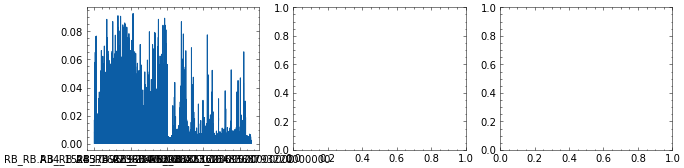

In [20]:
df_components = pd.read_csv("../data/1EE_final_components_V2/kmeans_components.csv", index_col="Unnamed: 0")
for i, component in enumerate(df_components.columns.values): 
    
    fig, ax = plt.subplots(1,3, figsize=(10.5, 2.625))
    df_components[component].plot(ax=ax[0])
    
    plot_log_hist(ax[1], W1_q2[~(bool_snapshot | bool_test),:,i], alpha=0.5)
    plot_log_hist(ax[1], W1_q2[bool_test,:,i], alpha=0.5)
    plot_log_hist(ax[1], W1_q2[bool_snapshot,:,i], alpha=0.5)
    ax[1].legend(["normal","test","snap"])
    
    plot_log_hist(ax[2], W2_q2[~(bool_snapshot | bool_test),:,i], alpha=0.5)
    plot_log_hist(ax[2], W2_q2[bool_test,:,i], alpha=0.5)
    plot_log_hist(ax[2], W2_q2[bool_snapshot,:,i], alpha=0.5)
    ax[2].legend(["normal","test","snap"])

# make plots seperatly for paper:

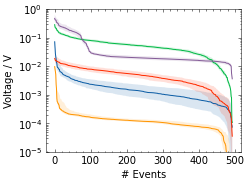

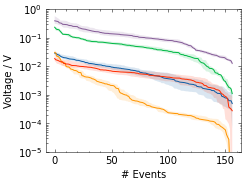

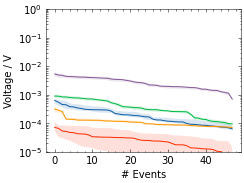

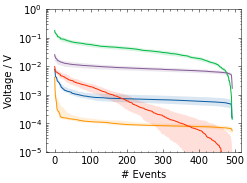

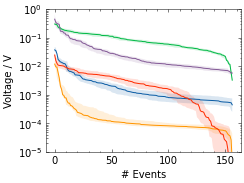

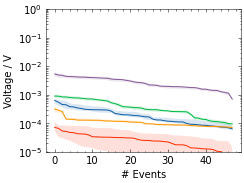

In [52]:
fig, ax = plt.subplots()
q1 = np.sort(W1_q1[~(bool_snapshot | bool_test)].max(axis=1), axis=0)[::-1]
q2 = np.sort(W1_q2[~(bool_snapshot | bool_test)].max(axis=1), axis=0)[::-1]
q3 = np.sort(W1_q3[~(bool_snapshot | bool_test)].max(axis=1), axis=0)[::-1]    

for i, q in enumerate(q2.T):
    ax.plot(q)
    ax.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax.set_ylabel("Voltage / V")
ax.set_xlabel("# Events")
ax.set_yscale("log")
ax.set_ylim((1e-5, 1))
plt.savefig("paper_plots/1EE_event_normal.svg")

fig, ax1 = plt.subplots()
q1 = np.sort(W1_q1[bool_test].max(axis=1), axis=0)[::-1]
q2 = np.sort(W1_q2[bool_test].max(axis=1), axis=0)[::-1]
q3 = np.sort(W1_q3[bool_test].max(axis=1), axis=0)[::-1]       
for i, q in enumerate(q2.T):
    ax1.plot(q)
    ax1.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax1.set_ylabel("Voltage / V")
ax1.set_xlabel("# Events")
ax1.set_yscale("log")
ax1.set_ylim(ax.get_ylim())
plt.savefig("paper_plots/1EE_event_fast_sec.svg")

fig, ax1 = plt.subplots()
q1 = np.sort(W1_q1[bool_snapshot].max(axis=1), axis=0)[::-1]
q2 = np.sort(W1_q2[bool_snapshot].max(axis=1), axis=0)[::-1]
q3 = np.sort(W1_q3[bool_snapshot].max(axis=1), axis=0)[::-1]       
for i, q in enumerate(q2.T):
    ax1.plot(q)
    ax1.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax1.set_ylabel("Voltage / V")
ax1.set_xlabel("# Events")
ax1.set_yscale("log")
ax1.set_ylim(ax.get_ylim())
plt.savefig("paper_plots/1EE_event_snap.svg")

fig, ax = plt.subplots()
q1 = np.sort(W2_q1[~(bool_snapshot | bool_test)].max(axis=1), axis=0)[::-1]
q2 = np.sort(W2_q2[~(bool_snapshot | bool_test)].max(axis=1), axis=0)[::-1]
q3 = np.sort(W2_q3[~(bool_snapshot | bool_test)].max(axis=1), axis=0)[::-1]        
for i, q in enumerate(q2.T):
    ax.plot(q)
    ax.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax.set_ylabel("Voltage / V")
ax.set_xlabel("# Events")
ax.set_yscale("log")
ax.set_ylim((1e-5, 1))
plt.savefig("paper_plots/2EE_event_normal.svg")

fig, ax1 = plt.subplots()
q1 = np.sort(W2_q1[bool_test].max(axis=1), axis=0)[::-1]
q2 = np.sort(W2_q2[bool_test].max(axis=1), axis=0)[::-1]
q3 = np.sort(W2_q3[bool_test].max(axis=1), axis=0)[::-1]        
for i, q in enumerate(q2.T):
    ax1.plot(q)
    ax1.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax1.set_ylabel("Voltage / V")
ax1.set_xlabel("# Events")
ax1.set_yscale("log")
ax1.set_ylim(ax.get_ylim())
plt.savefig("paper_plots/2EE_event_fast_sec.svg")

fig, ax1 = plt.subplots()
q1 = np.sort(W1_q1[bool_snapshot].max(axis=1), axis=0)[::-1]
q2 = np.sort(W1_q2[bool_snapshot].max(axis=1), axis=0)[::-1]
q3 = np.sort(W1_q3[bool_snapshot].max(axis=1), axis=0)[::-1]        
for i, q in enumerate(q2.T):
    ax1.plot(q)
    ax1.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax1.set_ylabel("Voltage / V")
ax1.set_xlabel("# Events")
ax1.set_yscale("log")
ax1.set_ylim(ax.get_ylim())
plt.savefig("paper_plots/2EE_event_snap.svg")

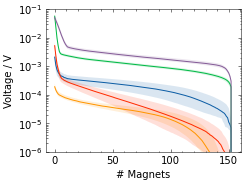

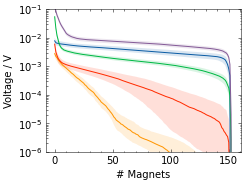

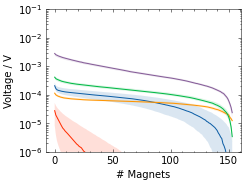

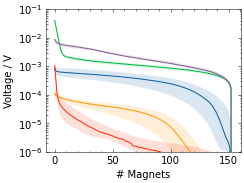

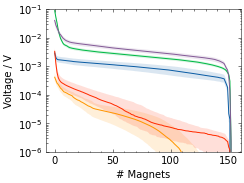

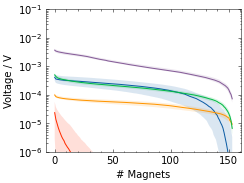

In [54]:
fig, ax = plt.subplots()
q1 = np.sort(W1_q1[~(bool_snapshot | bool_test)], axis=1).mean(axis=0)[::-1]
q2 = np.sort(W1_q2[~(bool_snapshot | bool_test)], axis=1).mean(axis=0)[::-1]
q3 = np.sort(W1_q3[~(bool_snapshot | bool_test)], axis=1).mean(axis=0)[::-1]        
for i, q in enumerate(q2.T):
    ax.plot(q)
    ax.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax.set_ylabel("Voltage / V")
ax.set_xlabel("# Magnets")
ax.set_yscale("log")
ax.set_ylim((1e-6, 1e-1))
plt.savefig("paper_plots/1EE_mag_normal.svg")

fig, ax1 = plt.subplots()
q1 = np.sort(W1_q1[bool_test], axis=1).mean(axis=0)[::-1]
q2 = np.sort(W1_q2[bool_test], axis=1).mean(axis=0)[::-1]
q3 = np.sort(W1_q3[bool_test], axis=1).mean(axis=0)[::-1]       
for i, q in enumerate(q2.T):
    ax1.plot(q)
    ax1.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax1.set_ylabel("Voltage / V")
ax1.set_xlabel("# Magnets")
ax1.set_yscale("log")
ax1.set_ylim(ax.get_ylim())
plt.savefig("paper_plots/1EE_mag_fast_sec.svg")

fig, ax1 = plt.subplots()
q1 = np.sort(W1_q1[bool_snapshot], axis=1).mean(axis=0)[::-1]
q2 = np.sort(W1_q2[bool_snapshot], axis=1).mean(axis=0)[::-1]
q3 = np.sort(W1_q3[bool_snapshot], axis=1).mean(axis=0)[::-1]       
for i, q in enumerate(q2.T):
    ax1.plot(q)
    ax1.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax1.set_ylabel("Voltage / V")
ax1.set_xlabel("# Magnets")
ax1.set_yscale("log")
ax1.set_ylim(ax.get_ylim())
plt.savefig("paper_plots/1EE_mag_snap.svg")

fig, ax = plt.subplots()
q1 = np.sort(W2_q1[~(bool_snapshot | bool_test)], axis=1).mean(axis=0)[::-1]
q2 = np.sort(W2_q2[~(bool_snapshot | bool_test)], axis=1).mean(axis=0)[::-1]
q3 = np.sort(W2_q3[~(bool_snapshot | bool_test)], axis=1).mean(axis=0)[::-1]        
for i, q in enumerate(q2.T):
    ax.plot(q)
    ax.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax.set_ylabel("Voltage / V")
ax.set_xlabel("# Magnets")
ax.set_yscale("log")
ax.set_ylim((1e-6, 1e-1))
plt.savefig("paper_plots/2EE_mag_normal.svg")

fig, ax1 = plt.subplots()
q1 = np.sort(W2_q1[bool_test], axis=1).mean(axis=0)[::-1]
q2 = np.sort(W2_q2[bool_test], axis=1).mean(axis=0)[::-1]
q3 = np.sort(W2_q3[bool_test], axis=1).mean(axis=0)[::-1]        
for i, q in enumerate(q2.T):
    ax1.plot(q)
    ax1.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax1.set_ylabel("Voltage / V")
ax1.set_xlabel("# Magnets")
ax1.set_yscale("log")
ax1.set_ylim(ax.get_ylim())
plt.savefig("paper_plots/2EE_mag_fast_sec.svg")

fig, ax1 = plt.subplots()
q1 = np.sort(W2_q1[bool_snapshot], axis=1).mean(axis=0)[::-1]
q2 = np.sort(W2_q2[bool_snapshot], axis=1).mean(axis=0)[::-1]
q3 = np.sort(W2_q3[bool_snapshot], axis=1).mean(axis=0)[::-1]        
for i, q in enumerate(q2.T):
    ax1.plot(q)
    ax1.fill_between(np.arange(len(q)), q1.T[i], q3.T[i], alpha=.15)
ax1.set_ylabel("Voltage / V")
ax1.set_xlabel("# Magnets")
ax1.set_yscale("log")
ax1.set_ylim(ax.get_ylim())
plt.savefig("paper_plots/2EE_mag_snap.svg")